# **Assignent 2: Topic Modelling**

### **Import Packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas --upgrade
!pip install matplotlib --upgrade

In [ ]:
pip install pyLDAvis

In [ ]:
pip install openpyxl==3.0.0

In [ ]:
pip install sweetviz

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

#Report
import sweetviz as sv

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### **Prepare Stopwords**

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

### **Importing Oberoi Hotel reviews Data**

In [ ]:
# Import Dataset
df = pd.read_excel('/content/drive/MyDrive/Text_Analytics/Assignment 2/oberoi_mumbai.xlsx')
df.head()

revTitle  ...                                             review
0  Staff!!!! Extremely courteous and hospitable  ...     One of the best hotels we have ever stayed ...
1   Definitely an experience, than just a stay.  ...     Spent my birthday here, and needless to say...
2               Weekend staycation during rains  ...     Would really like to appreciate the luxury ...
3                  Excellent Hotel and Stay Too  ...     A lovely and hospitable experience yet agai...
4                 Relaxing and luxurious stay!!  ...     We stayed for a night at The Oberoi and it ...

[5 rows x 5 columns]

### **EDA**

In [ ]:
data = pd.DataFrame(df)
my_report = sv.analyze(data)
my_report.show_html() 

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
import plotly.express as px

fig1 = px.histogram(df, x="rating",color="rating")
fig2 = px.histogram(df, x="date",y="rating",color="rating") 
fig1.show()
fig2.show()

### **Text Cleansing**

In [ ]:
# Replace email address with 'emailaddress'
df['review'] = df['review'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['review'] = df['review'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['review'] = df['review'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
df['review'] = df['review'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
df['review'] = df['review'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
df['review'] = df['review'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
df['review'] = df['review'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
df['review'] = df['review'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
df['review'] = df['review'].str.lower()

# remove non alphabets with whitespace
df['review'] = df['review'].str.replace(r'[^a-zA-Z]', ' ')

In [ ]:
df.review.head()

0     one of the best hotels we have ever stayed in...
1     spent my birthday here and needless to say it...
2     would really like to appreciate the luxury ex...
3     a lovely and hospitable experience yet again ...
4     we stayed for a night at the oberoi and it wa...
Name: review, dtype: object

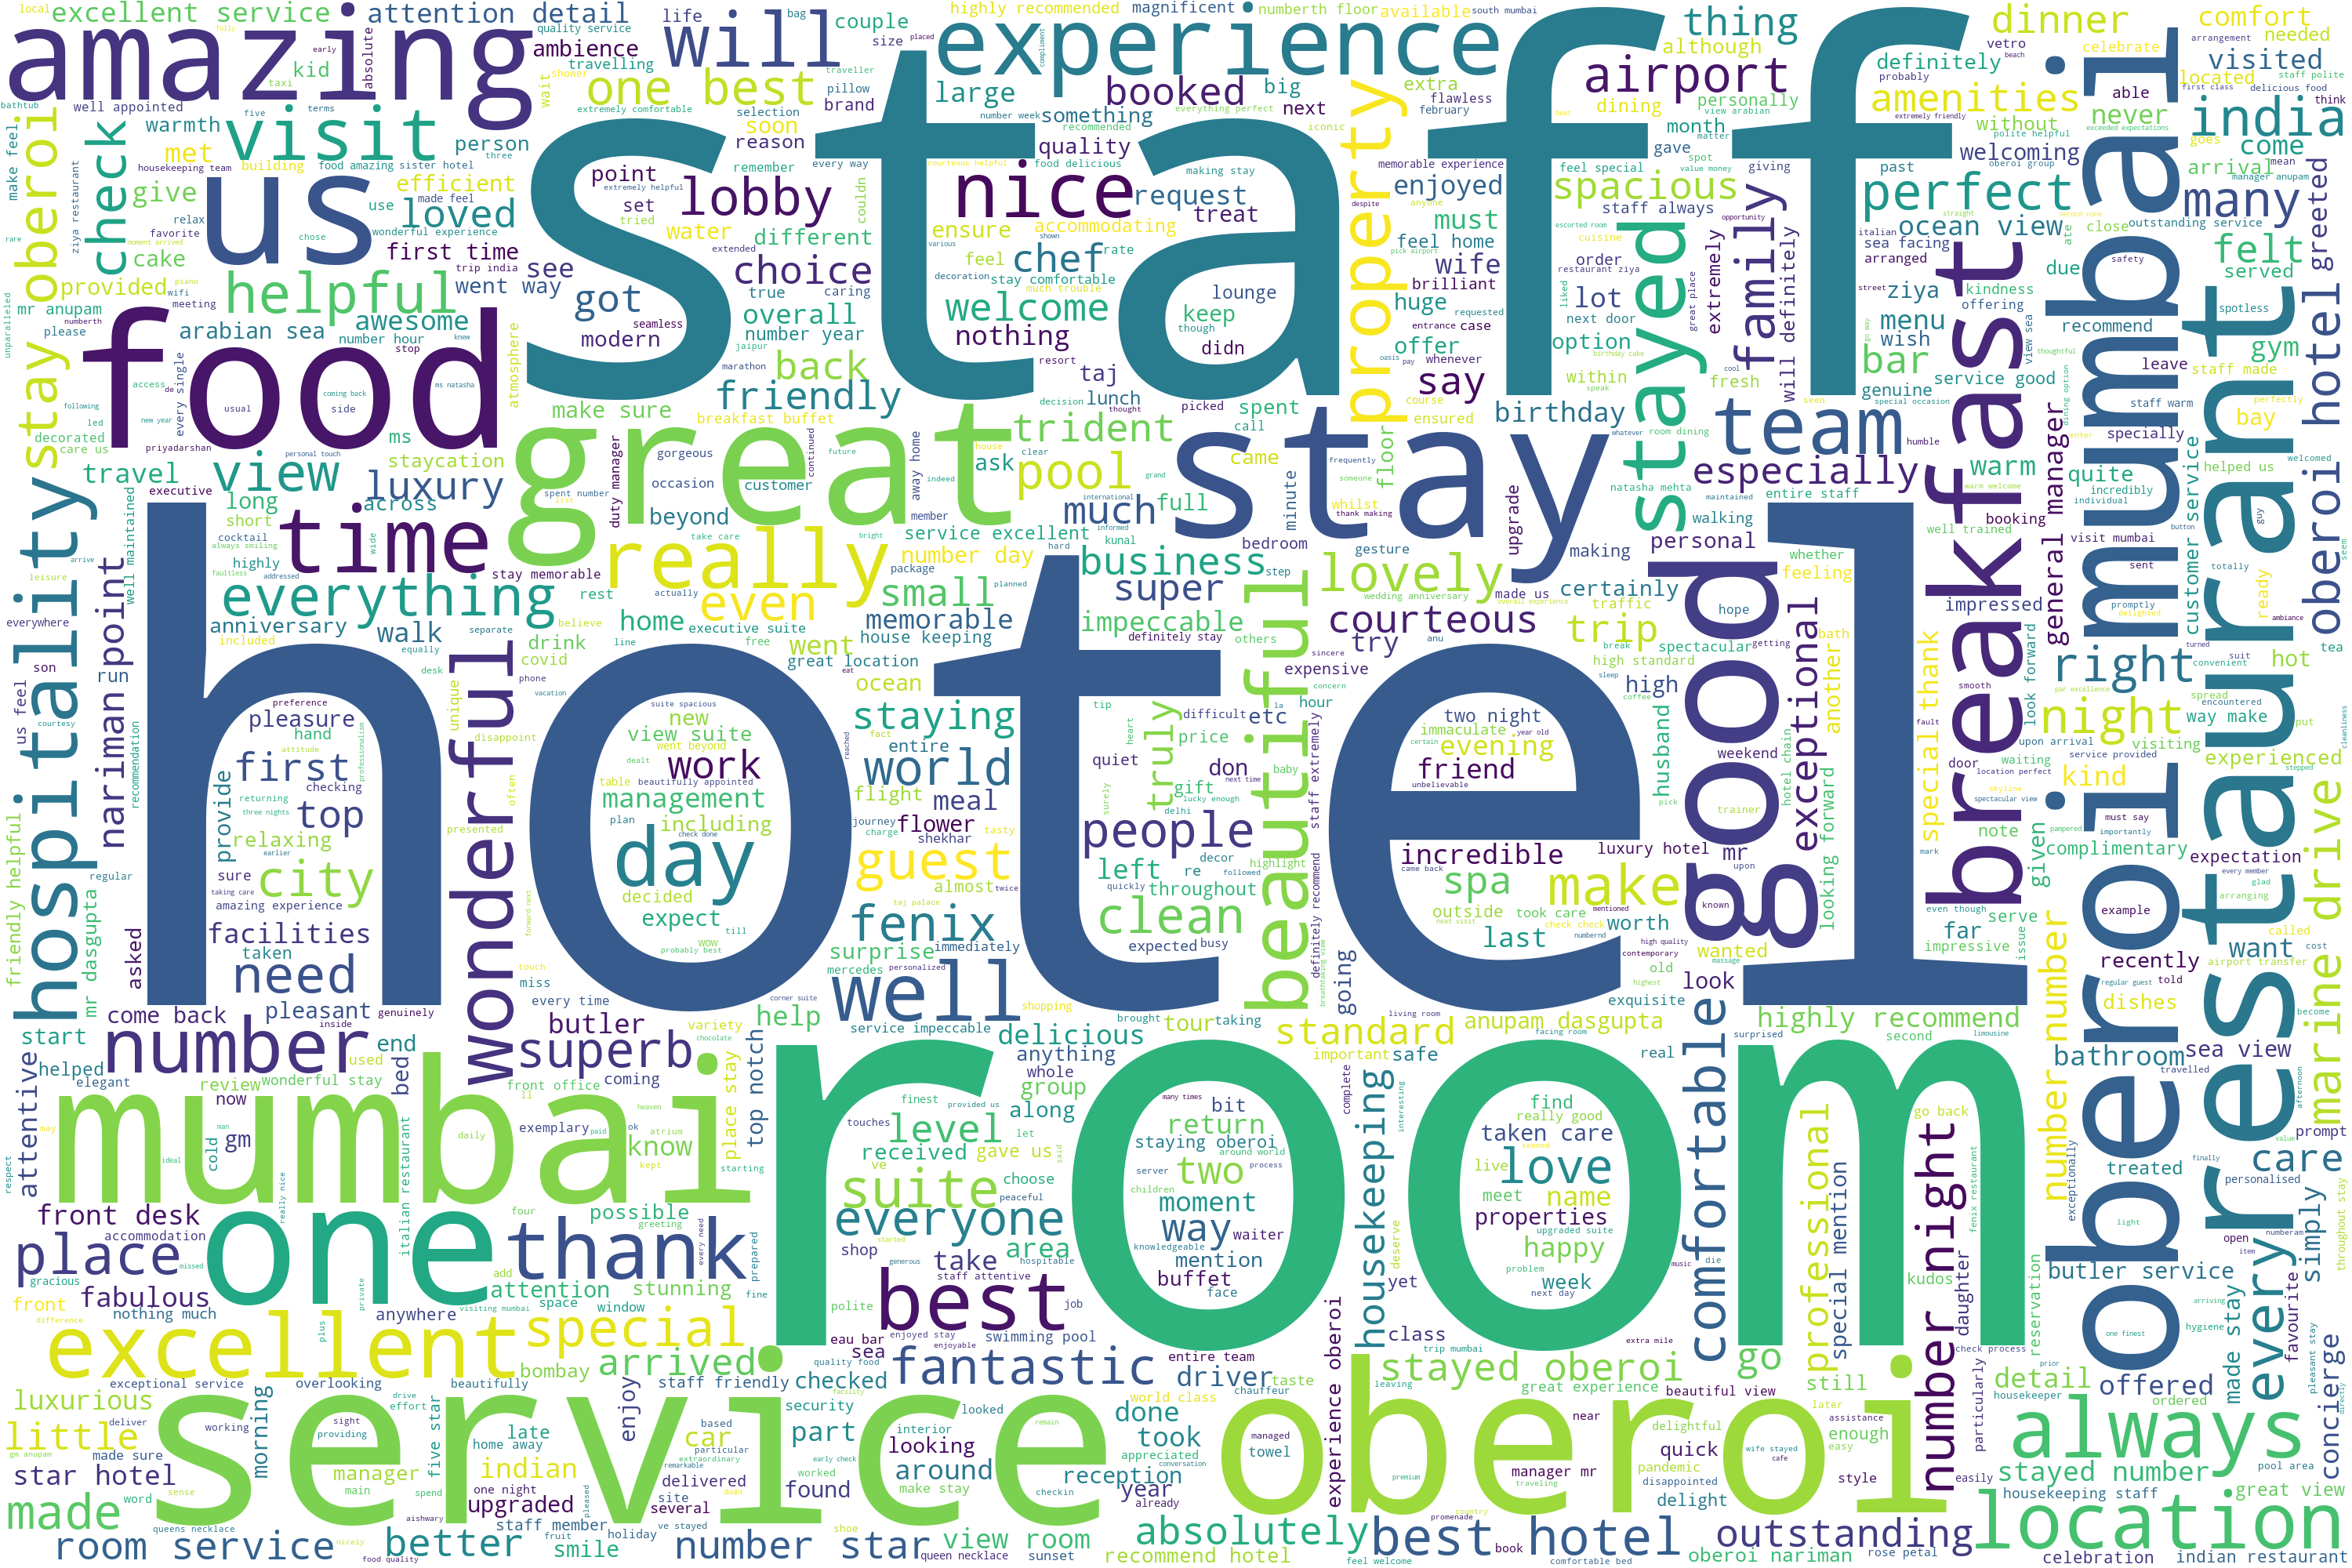

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['review'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=25, width = 3000, height = 2000,contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### **Tokenize words and Clean-up text**

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['review']))
print(data_words[:1])


[['one', 'of', 'the', 'best', 'hotels', 'we', 'have', 'ever', 'stayed', 'in', 'number', 'kudos', 'to', 'the', 'amazing', 'staff', 'across', 'room', 'service', 'restaurants', 'number', 'food', 'to', 'die', 'for', 'sushis', 'are', 'must', 'have', 'number', 'eau', 'bar', 'probably', 'has', 'the', 'best', 'view', 'in', 'city']]


### **Create Bigram and Trigram Models**

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['one', 'of', 'the', 'best', 'hotels', 'we', 'have', 'ever', 'stayed', 'in', 'number', 'kudos', 'to', 'the', 'amazing', 'staff', 'across', 'room', 'service', 'restaurants', 'number', 'food', 'to', 'die', 'for', 'sushis', 'are', 'must', 'have', 'number', 'eau_bar', 'probably', 'has', 'the', 'best', 'view', 'in', 'city']


### **Remove Stopwords, Make Bigrams and Lemmatize**

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [ ]:
# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['good', 'hotel', 'ever', 'stay', 'number', 'kudo', 'amazing', 'staff', 'room', 'service', 'restaurant', 'number', 'food', 'die', 'sushis', 'must', 'number', 'probably', 'best', 'view', 'city']]


In [ ]:
wordlist = ' '.join(map(str, data_lemmatized))

In [ ]:
wordlist  = wordlist.replace("'", "")
wordlist

'[good, hotel, ever, stay, number, kudo, amazing, staff, room, service, restaurant, number, food, die, sushis, must, number, probably, best, view, city] [spend, birthday, needless, say, style, room, room, amenity, already, delight, staff, really, top, service, birthday, treat, surprise, personal_touch, service, truly, exceptional, special, shout, shekhar, check, add, experience] [would, really, like, appreciate, luxury, experience, stay, number, do, booking, directly, manager, swift, call, good, deal, could, ask, actually, want, think, experience, oberoi, first, time, hospitality, pamper, epitome, luxury, staff, courteous, soft, speak, helpful, special, mention, staff, give, good, anniversary, experience, right, decorate, room, pamper, complimentary, starter, desert, would, really, recommend, experience, breathtake, view] [lovely, hospitable, experience, team, excellent, service, special, shout, sooraj, always, extremely, helpful, many, lovely, stay, thank, team] [stay, night, oberoi, 

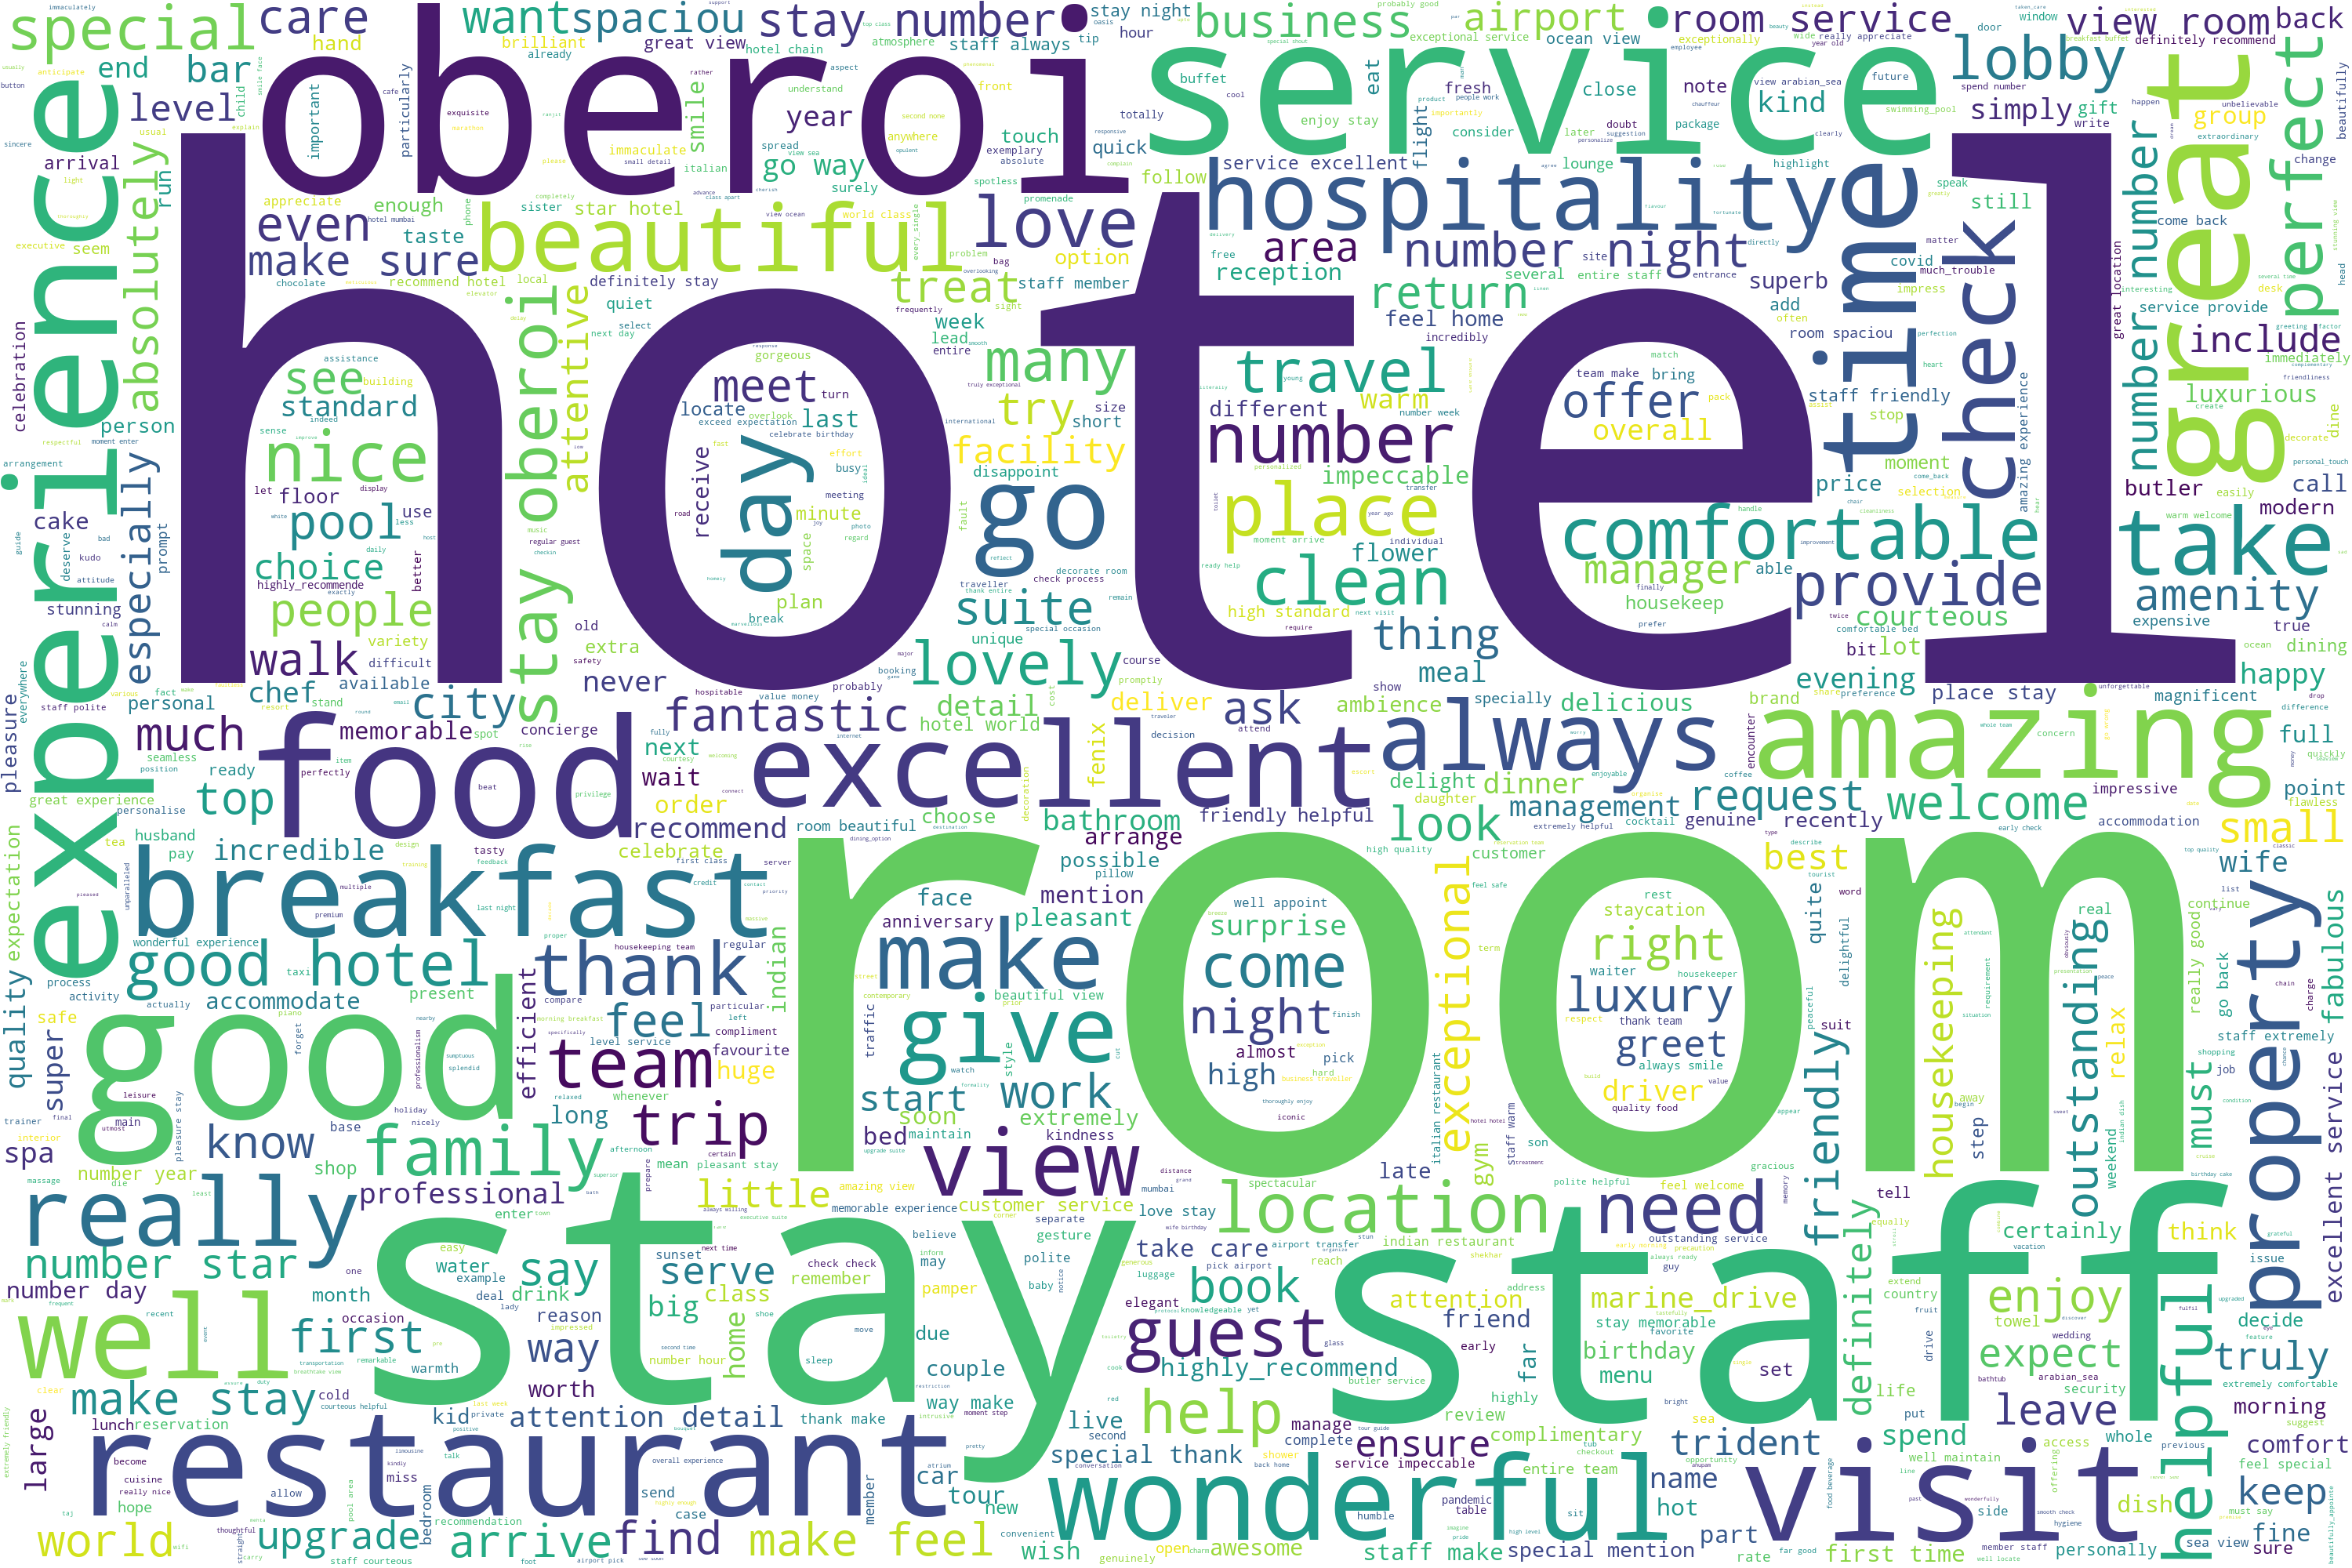

In [ ]:
# Generate a word cloud
wordcloud.generate(wordlist)

# Visualize the word cloud
wordcloud.to_image()

### **Create the Dictionary and Corpus needed for Topic Modeling**

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


## **Building the Topic Model**

### **LSI Model**

In [ ]:
from gensim import corpora, models
lsi_model = models.LsiModel(corpus=corpus, num_topics=10, id2word=id2word)
lsi_model.show_topics(num_topics=5)

[(0,
  '0.440*"hotel" + 0.386*"stay" + 0.314*"room" + 0.252*"staff" + 0.228*"number" + 0.223*"service" + 0.196*"oberoi" + 0.186*"good" + 0.150*"make" + 0.121*"experience"'),
 (1,
  '-0.533*"stay" + 0.513*"room" + 0.393*"hotel" + -0.229*"make" + -0.225*"oberoi" + -0.183*"staff" + -0.116*"thank" + 0.107*"good" + -0.098*"special" + 0.097*"service"'),
 (2,
  '-0.680*"hotel" + 0.558*"room" + 0.269*"number" + -0.170*"good" + 0.130*"check" + 0.118*"view" + 0.068*"night" + -0.058*"experience" + 0.054*"day" + 0.053*"go"'),
 (3,
  '-0.738*"number" + 0.327*"good" + -0.255*"hotel" + 0.226*"staff" + 0.154*"service" + 0.142*"great" + 0.127*"view" + 0.122*"room" + 0.097*"really" + 0.085*"excellent"'),
 (4,
  '0.703*"good" + -0.356*"staff" + 0.283*"number" + -0.214*"make" + -0.191*"hotel" + 0.186*"service" + 0.157*"stay" + -0.131*"feel" + -0.111*"room" + -0.078*"welcome"')]

In [ ]:
# Compute Coherence Score
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()
print('Coherence Score: ', coherence_lsi)

Coherence Score:  0.37138711660024637


### **LDA Model**

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### **View the topics in LDA model**

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.050*"stay" + 0.039*"staff" + 0.025*"good" + 0.024*"hotel" + '
  '0.023*"service" + 0.023*"oberoi" + 0.023*"make" + 0.016*"go" + 0.016*"food" '
  '+ 0.014*"experience"'),
 (1,
  '0.015*"tour" + 0.011*"morning" + 0.011*"dish" + 0.010*"cold" + 0.010*"nice" '
  '+ 0.010*"concierge" + 0.009*"buffet" + 0.009*"hot" + 0.009*"security" + '
  '0.008*"well"'),
 (2,
  '0.053*"number" + 0.017*"time" + 0.015*"year" + 0.012*"check" + '
  '0.011*"airport" + 0.011*"take" + 0.009*"give" + 0.009*"day" + 0.008*"greet" '
  '+ 0.008*"request"'),
 (3,
  '0.057*"hotel" + 0.047*"room" + 0.020*"view" + 0.020*"service" + '
  '0.013*"well" + 0.013*"stay" + 0.012*"good" + 0.012*"restaurant" + '
  '0.012*"number" + 0.012*"breakfast"'),
 (4,
  '0.029*"recommend" + 0.016*"enough" + 0.012*"price" + 0.012*"group" + '
  '0.011*"highly" + 0.011*"recently" + 0.010*"may" + 0.010*"chain" + '
  '0.009*"modern" + 0.009*"close"')]


### **Compute Model Perplexity and Coherence Score**

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.862903339541908

Coherence Score:  0.3829769783170604


### **Hyperparameter tuning**

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    best_parms = pd.DataFrame(model_results)
    pbar.close()


100%|██████████| 540/540 [1:16:02<00:00,  8.45s/it]


In [ ]:

sorted_df = best_parms.sort_values(["Coherence"], 
                                   ascending=False)
print(sorted_df)

    Validation_Set  Topics      Alpha  Beta  Coherence
198     75% Corpus       8       0.91  0.91   0.674792
253     75% Corpus      10       0.61  0.91   0.665388
528    100% Corpus      10       0.91  0.91   0.660014
257     75% Corpus      10       0.91  0.61   0.654975
222     75% Corpus       9       0.61  0.61   0.635682
..             ...     ...        ...   ...        ...
91      75% Corpus       5       0.01  0.31   0.302623
111     75% Corpus       5  symmetric  0.31   0.297021
463    100% Corpus       8       0.61  0.91   0.296677
107     75% Corpus       5       0.91  0.61   0.281895
61      75% Corpus       4       0.01  0.31   0.275104

[540 rows x 5 columns]


### **Final Model**

In [ ]:
num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.91,
                                           eta=0.91)

In [ ]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"repair" + 0.000*"bath" + 0.000*"major" + 0.000*"refreshment" + '
  '0.000*"maintenance" + 0.000*"numberth_floor" + 0.000*"operate" + '
  '0.000*"example" + 0.000*"bedroom" + 0.000*"display"'),
 (1,
  '0.000*"dress" + 0.000*"pristine" + 0.000*"cream" + 0.000*"plain" + '
  '0.000*"goodness" + 0.000*"fluffy" + 0.000*"connect" + 0.000*"tailor" + '
  '0.000*"propertie" + 0.000*"clearly"'),
 (2,
  '0.010*"number" + 0.007*"airport" + 0.006*"check" + 0.005*"car" + '
  '0.005*"water" + 0.004*"flight" + 0.004*"transfer" + 0.003*"include" + '
  '0.003*"hour" + 0.003*"late"'),
 (3,
  '0.000*"dress" + 0.000*"pristine" + 0.000*"plain" + 0.000*"fluffy" + '
  '0.000*"goodness" + 0.000*"connect" + 0.000*"tailor" + 0.000*"clearly" + '
  '0.000*"propertie" + 0.000*"walkable"'),
 (4,
  '0.000*"dress" + 0.000*"pristine" + 0.000*"plain" + 0.000*"fluffy" + '
  '0.000*"goodness" + 0.000*"connect" + 0.000*"tailor" + 0.000*"clearly" + '
  '0.000*"propertie" + 0.000*"walkable"'),
 (5,
  '0.001*"pr

### **Visualize the topics-keywords**

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.249231 -0.003209       1        1  73.136791
2     -0.019461  0.048975       2        1   8.727063
6     -0.038416 -0.007813       3        1   3.058321
0     -0.038197 -0.007507       4        1   3.058155
5     -0.038646 -0.008258       5        1   3.043612
1     -0.038175 -0.007396       6        1   2.999620
4     -0.038168 -0.007396       7        1   2.988221
3     -0.038168 -0.007396       8        1   2.988217, topic_info=           Term        Freq       Total Category  logprob  loglift
10       number  363.000000  363.000000  Default  30.0000  30.0000
7         hotel  872.000000  872.000000  Default  29.0000  29.0000
16         stay  744.000000  744.000000  Default  28.0000  28.0000
23        check  127.000000  127.000000  Default  27.0000  27.0000
523     airport   54.000000   54.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
575     usually    0.400867    8.149641   Topic8  -7.8802   0.4984
2941    clearly    0.409640   10.575693   Topic8  -7.8586   0.2595
1028    refresh    0.390444    6.239382   Topic8  -7.9066   0.7391
2926    charger    0.387722    5.898264   Topic8  -7.9136   0.7884
1094  exquisite    0.393568   13.326847   Topic8  -7.8986  -0.0118

[550 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2264      1  0.325061         ab
2264      2  0.325061         ab
208       1  0.547143     access
208       2  0.328286     access
885       1  0.407508  accompany
...     ...       ...        ...
172       2  0.006942  wonderful
2673      1  0.436254    workout
2673      2  0.218127    workout
75        1  0.981425      would
75        2  0.006332      would

[583 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 7, 1, 6, 2, 5, 4])

### **LDA Mallet Model**

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('hotel', 0.1612239650295706),
   ('number', 0.11828233479043455),
   ('stay', 0.06968372332219079),
   ('give', 0.027513499614296735),
   ('world', 0.023656466958086913),
   ('time', 0.02262792491643096),
   ('work', 0.01979943430187709),
   ('travel', 0.019285163281049112),
   ('arrive', 0.019028027770635125),
   ('business', 0.016199537156081256)]),
 (1,
  [('room', 0.1359173126614987),
   ('check', 0.04909560723514212),
   ('night', 0.047028423772609816),
   ('day', 0.029974160206718347),
   ('lobby', 0.022222222222222223),
   ('suite', 0.021963824289405683),
   ('offer', 0.01808785529715762),
   ('book', 0.017829457364341085),
   ('leave', 0.014728682170542635),
   ('upgrade', 0.013953488372093023)]),
 (2,
  [('excellent', 0.05705312745354619),
   ('staff', 0.052604030358544884),
   ('wonderful', 0.0450143941376603),
   ('breakfast', 0.04475268254383669),
   ('comfortable', 0.036639623135304895),
   ('friendly', 0.028788275320596704),
   ('food', 0.027218005757655064),
   

### **Optimal number of topics for LDA**

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

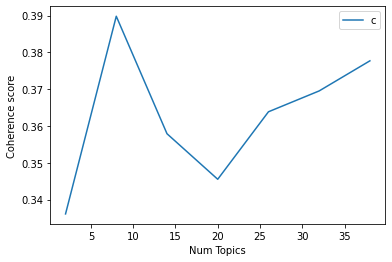

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3361
Num Topics = 8  has Coherence Value of 0.3898
Num Topics = 14  has Coherence Value of 0.3579
Num Topics = 20  has Coherence Value of 0.3455
Num Topics = 26  has Coherence Value of 0.3639
Num Topics = 32  has Coherence Value of 0.3695
Num Topics = 38  has Coherence Value of 0.3777


In [ ]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.195*"room" + 0.076*"view" + 0.032*"location" + 0.030*"nice" + '
  '0.027*"place" + 0.022*"lobby" + 0.022*"clean" + 0.021*"comfortable" + '
  '0.018*"spacious" + 0.016*"fantastic"'),
 (1,
  '0.128*"number" + 0.049*"hotel" + 0.048*"check" + 0.045*"night" + '
  '0.042*"day" + 0.032*"give" + 0.017*"book" + 0.015*"suite" + 0.014*"star" + '
  '0.013*"request"'),
 (2,
  '0.086*"staff" + 0.048*"special" + 0.047*"team" + 0.041*"make" + '
  '0.040*"helpful" + 0.033*"property" + 0.029*"guest" + 0.020*"extremely" + '
  '0.019*"outstanding" + 0.018*"warm"'),
 (3,
  '0.146*"service" + 0.059*"oberoi" + 0.026*"provide" + 0.023*"detail" + '
  '0.018*"quality" + 0.018*"small" + 0.016*"attention" + 0.016*"trip" + '
  '0.016*"smile" + 0.015*"leave"'),
 (4,
  '0.156*"stay" + 0.074*"oberoi" + 0.062*"make" + 0.057*"staff" + 0.048*"feel" '
  '+ 0.036*"hospitality" + 0.027*"care" + 0.025*"family" + 0.024*"world" + '
  '0.021*"home"'),
 (5,
  '0.157*"hotel" + 0.077*"great" + 0.066*"time" + 0.055*"visi

### **Finding the dominant topic in each sentence**

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['review']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['review'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  ...                                               Text
0            0  ...   one of the best hotels we have ever stayed in...
1            1  ...   spent my birthday here and needless to say it...
2            2  ...   would really like to appreciate the luxury ex...
3            3  ...   a lovely and hospitable experience yet again ...
4            4  ...   we stayed for a night at the oberoi and it wa...
5            5  ...   one of the best hotels we have ever stayed in...
6            6  ...   spent my birthday here and needless to say it...
7            7  ...   would really like to appreciate the luxury ex...
8            8  ...   a lovely and hospitable experience yet again ...
9            9  ...   we stayed for a night at the oberoi and it wa...

[10 rows x 5 columns]

### **Finding the most representative document for each topic**


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

Topic_Num  ...                                               Text
0        0.0  ...   first stayed for a few days in the executive ...
1        1.0  ...   we had a group of number american tourists wh...
2        2.0  ...   amazing hospitality well cared for i have bee...
3        3.0  ...   this is my first time encountering the oberoi...
4        4.0  ...   from the moment we stepped into the lobby we ...

[5 rows x 4 columns]

### **Topic distribution across documents**

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

Dominant_Topic  ... Perc_Documents
0.0              1.0  ...          0.138
1.0              2.0  ...          0.124
2.0              7.0  ...          0.119
3.0              2.0  ...          0.103
4.0              2.0  ...          0.146
5.0              1.0  ...          0.100
6.0              3.0  ...          0.126
7.0              7.0  ...          0.144
8.0              2.0  ...            NaN
9.0              7.0  ...            NaN
10.0             1.0  ...            NaN
11.0             4.0  ...            NaN
12.0             4.0  ...            NaN
13.0             3.0  ...            NaN
14.0             7.0  ...            NaN
15.0             2.0  ...            NaN
16.0             7.0  ...            NaN
17.0             0.0  ...            NaN
18.0             7.0  ...            NaN
19.0             5.0  ...            NaN

[20 rows x 4 columns]